In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import seaborn as sns
import cmocean
from panco2 import PressureProfileFitter
from utils import gNFW
import results
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.ndimage import gaussian_filter
import os

# Integrated Y

/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


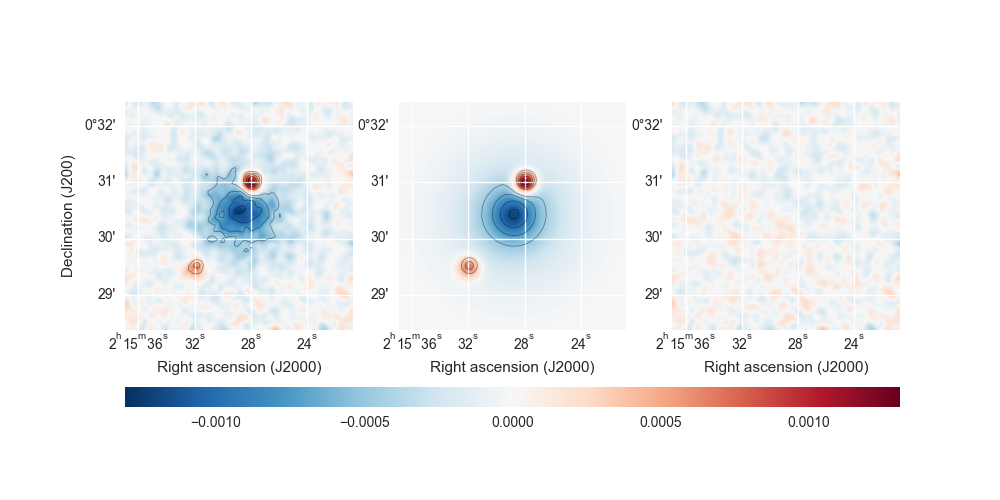

In [3]:
path = "../tests/testY0/"

ppf = PressureProfileFitter(
    f"{path}/map.fits", 1, 2,
    0.865, M_500=3.5e14, map_size=4.0,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(18.0/ 2.0)),
    np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30.0)),
    7
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0, 1e-3, 2e-3])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.add_point_sources([SkyCoord("2h15m32.00s +00d29m30.00s"), SkyCoord("2h15m28.00s +00d31m00.00s")], 18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4),
    ps_fluxes=[ss.norm(1e-3, 5e-4), ss.norm(2e-3, 1e-2)],
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.set_plot_style("seaborn")
_ = results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

### Create map

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=6.1
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)),
    np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)),
    50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.5, imrange="sym")
fig, ax = plt.subplots()
ax.loglog(r_bins, P_bins, "o-")

### Fit

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    f"{path}/map.fits", 1, 2,
    0.865, M_500=3.5e14, map_size=4.0,
)

r_bins = ppf.default_radial_binning(18.0 / 2)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.set_plot_style("seaborn")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=5e2, max_delta_tau=0.01, min_autocorr_times=100, out_chains_file=f"{path}/raw_chains.npz")
results.plot_acf(ppf, max_delta_tau=0.01, min_autocorr_times=100)

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Test 1

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=4.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

### Fit

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Test 2

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test2/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=5.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
mapview.fitsview(f"{path}/map.fits", 1, smooth=1.0, imrange="sym")

### Fit

In [ ]:
path = "../tests/test2/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
    map_size=4.0
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
plt.close("all")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(ppf.autocorr[0], ppf.autocorr[1], "o-")
axs[1].semilogy(ppf.autocorr[0, 1:], np.ediff1d(ppf.autocorr[1]) / ppf.autocorr[1, :-1], "o-")

In [ ]:
np.roll(np.arange(5), 1)

## Test 3

- $M_{500} = 5.5 \times 10^{14} \, M_\odot$, $z= 0.565$
- A10 pressure profile
- 6 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test3/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.565, M_500=5.5e14, map_size=6.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

### Fit

In [ ]:
path = "../tests/test3/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.565,
    M_500=5.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 8
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Test 4

- $M_{500} = 5 \times 10^{14} \, M_\odot$, $z = 0.1$
- A10 pressure profile
- 30 arcmin map, 1 arcmin FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test4/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/ACTlike.fits",
    1, 2, 0.1, M_500=5e14, map_size=61.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)), np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])

ppf.add_filtering(beam_fwhm=60.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=True)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.0, imrange="sym")

### Fit

In [ ]:
path = "../tests/test4/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1, 2, 0.1, M_500=5e14, map_size=11.0
)

#r_bins = np.logspace(
#    np.log10(ppf.cluster.arcsec2kpc(30.0)), np.log10(ppf.cluster.arcsec2kpc(15.0 * 60)), 8
#)

r_bins = ppf.default_radial_binning(60.0)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=60.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(1.0, 0.1),
    zero=ss.norm(0.0, 1e-6)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=0)

In [ ]:
f = ppf.run_mcmc(30, 1e5, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
results.plot_acf(ppf, max_delta_tau=0.01, min_autocorr_times=100)

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 1000, 100)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
#results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, show_probs=False, filename=f"{path}/trace.png")
#fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
#fig.savefig(f"{path}/results.pdf")

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=5e2, max_delta_tau=0.02, min_autocorr_times=50, out_chains_file=f"{path}/raw_chains.npz")

In [4]:
chains_clean_noY = results.load_chains(f"{path}/raw_chains.npz", 500, 10)
plt.close("all")
results.set_plot_style("seaborn")
results.plot_acf(ppf, max_delta_tau=0.02, min_autocorr_times=50)

AttributeError: 'PressureProfileFitter' object has no attribute 'autocorr'

In [ ]:
results.mcmc_trace_plot(chains_clean_noY, filename=f"{path}/trace.png")
results.mcmc_corner_plot(chains_clean_noY, filename=f"{path}/corner.png", model=ppf.model)
ax = results.plot_profile(chains_clean_noY, ppf, r_range=np.linspace(ppf.model.r_bins.min(), ppf.model.r_bins.max(), 100))
_ = results.plot_data_model_residuals(ppf, par_vec=ppf.model.par_dic2vec(chains_clean_noY.median()), lims="sym", smooth=1.0)

In [25]:
path = "../tests/testY1/"
ppf.add_integ_Y(28.0, 2.8, 800.0)

In [26]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=5e2, max_delta_tau=0.02, min_autocorr_times=50, out_chains_file=f"{path}/raw_chains.npz")

I'll stop when the autocorrelation length has changed by less than 2.0\% twice in a row, and the chain is longer than 50*tau


/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|                                                                     | 0/50000 [00:00<?, ?it/s]/Users/fkeruzore/panco2/panco2/model.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  - self.r_integ_Y[i] ** (3.0 - alphas[i])
  0%|                                                            | 10/50000 [00:00<45:37, 18.26it/s]/Users/fkeruzore/panco2/panco2/model.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  - self.r_integ_Y[i] ** (3.0 - alphas[i])
  0%|                                                            | 16/50000 [00:00<45:55, 18.14it/s]/Users/fkeruzore/panco2/panco2/model.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  - self.r_integ_Y[i] ** (3.0 - alphas[i])
/Users/fkeruzore/panco2/panco2/model.py:197: RuntimeWarning: divide by zero en

False False False
    500 iterations = 12.3*tau (tau = 40.7 -> dtau/tau = 1.0000)


  2%|█▏                                                        | 1002/50000 [00:56<46:54, 17.41it/s]

False False False
    1000 iterations = 14.2*tau (tau = 70.4 -> dtau/tau = 0.4217)


  3%|█▋                                                        | 1502/50000 [01:24<50:14, 16.09it/s]

False False False
    1500 iterations = 15.5*tau (tau = 96.9 -> dtau/tau = 0.2737)


  4%|██▎                                                       | 2002/50000 [01:52<47:03, 17.00it/s]

False False False
    2000 iterations = 17.0*tau (tau = 117.4 -> dtau/tau = 0.1744)


  5%|██▉                                                       | 2502/50000 [02:20<49:42, 15.92it/s]

False False False
    2500 iterations = 18.7*tau (tau = 133.4 -> dtau/tau = 0.1199)


  6%|███▍                                                      | 3002/50000 [02:48<49:48, 15.73it/s]

False False False
    3000 iterations = 20.0*tau (tau = 150.1 -> dtau/tau = 0.1113)


  7%|████                                                      | 3502/50000 [03:17<49:33, 15.64it/s]

False False False
    3500 iterations = 21.7*tau (tau = 161.5 -> dtau/tau = 0.0704)


  8%|████▋                                                     | 4002/50000 [03:45<51:14, 14.96it/s]

False False False
    4000 iterations = 23.8*tau (tau = 167.9 -> dtau/tau = 0.0378)


  9%|█████▏                                                    | 4502/50000 [04:15<55:35, 13.64it/s]

False False False
    4500 iterations = 25.5*tau (tau = 176.2 -> dtau/tau = 0.0473)


 10%|█████▊                                                    | 5002/50000 [04:44<54:53, 13.66it/s]

False False False
    5000 iterations = 27.2*tau (tau = 184.0 -> dtau/tau = 0.0424)


 11%|██████▍                                                   | 5502/50000 [05:14<52:03, 14.24it/s]

False False False
    5500 iterations = 29.0*tau (tau = 190.0 -> dtau/tau = 0.0314)


 12%|██████▉                                                   | 6002/50000 [05:43<53:37, 13.67it/s]

False False False
    6000 iterations = 30.0*tau (tau = 200.0 -> dtau/tau = 0.0500)


 13%|███████▌                                                  | 6502/50000 [06:13<54:36, 13.28it/s]

False False False
    6500 iterations = 31.1*tau (tau = 209.0 -> dtau/tau = 0.0432)


 14%|████████                                                  | 7002/50000 [06:42<54:15, 13.21it/s]

False False False
    7000 iterations = 32.3*tau (tau = 216.5 -> dtau/tau = 0.0348)


 15%|████████▋                                                 | 7502/50000 [07:11<52:06, 13.59it/s]

True False False
    7500 iterations = 34.0*tau (tau = 220.6 -> dtau/tau = 0.0186)


 16%|█████████▎                                                | 8002/50000 [07:40<49:16, 14.21it/s]

False True False
    8000 iterations = 34.7*tau (tau = 230.8 -> dtau/tau = 0.0440)


 17%|█████████▌                                              | 8502/50000 [08:09<1:03:30, 10.89it/s]

True False False
    8500 iterations = 36.5*tau (tau = 232.8 -> dtau/tau = 0.0086)


 18%|██████████                                              | 9002/50000 [08:38<1:01:23, 11.13it/s]

True True False
    9000 iterations = 38.2*tau (tau = 235.6 -> dtau/tau = 0.0118)


 19%|██████████▋                                             | 9502/50000 [09:07<1:02:29, 10.80it/s]

True True False
    9500 iterations = 39.9*tau (tau = 237.8 -> dtau/tau = 0.0095)


 20%|███████████▍                                             | 10002/50000 [09:37<59:58, 11.12it/s]

True True False
    10000 iterations = 42.6*tau (tau = 234.6 -> dtau/tau = 0.0137)


 21%|███████████▌                                           | 10502/50000 [10:07<1:02:19, 10.56it/s]

True True False
    10500 iterations = 44.5*tau (tau = 235.7 -> dtau/tau = 0.0047)


 22%|████████████                                           | 11002/50000 [10:37<1:01:01, 10.65it/s]

True True False
    11000 iterations = 46.4*tau (tau = 237.3 -> dtau/tau = 0.0068)


 23%|█████████████                                            | 11502/50000 [11:06<56:46, 11.30it/s]

True True False
    11500 iterations = 48.6*tau (tau = 236.7 -> dtau/tau = 0.0027)


 24%|█████████████▋                                           | 12000/50000 [11:35<36:42, 17.25it/s]

True True True
    12000 iterations = 50.2*tau (tau = 238.8 -> dtau/tau = 0.0091)
    -> Convergence achieved
Running time: 00h11m36s


(<Figure size 800x550 with 2 Axes>,
 array([<AxesSubplot:ylabel='Integrated autocorrelation time $\\tau_i$'>,
        <AxesSubplot:xlabel='MCMC step $i$', ylabel='$|\\tau_{i - 1} - \\tau_{i}| \\; / \\; \\tau_{i}$'>],
       dtype=object))

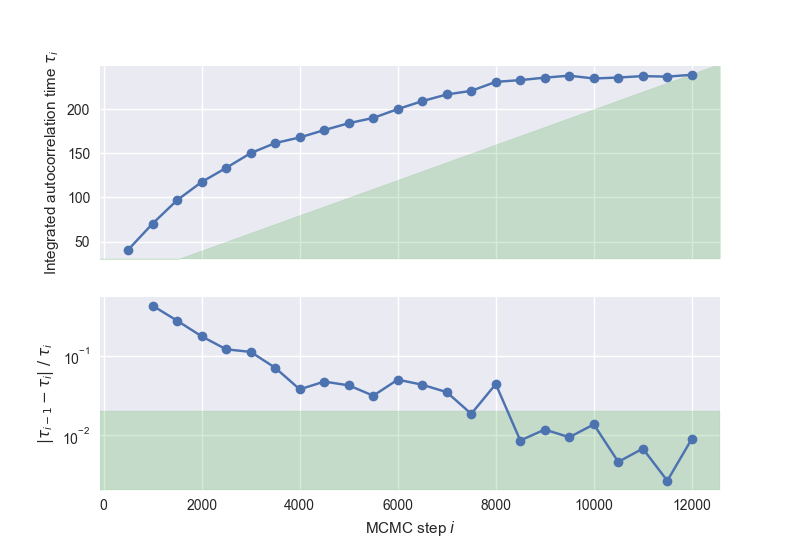

In [27]:
chains_clean_noY = results.load_chains(f"{path}/raw_chains.npz", 500, 10)
plt.close("all")
results.set_plot_style("seaborn")
results.plot_acf(ppf, max_delta_tau=0.02, min_autocorr_times=50)

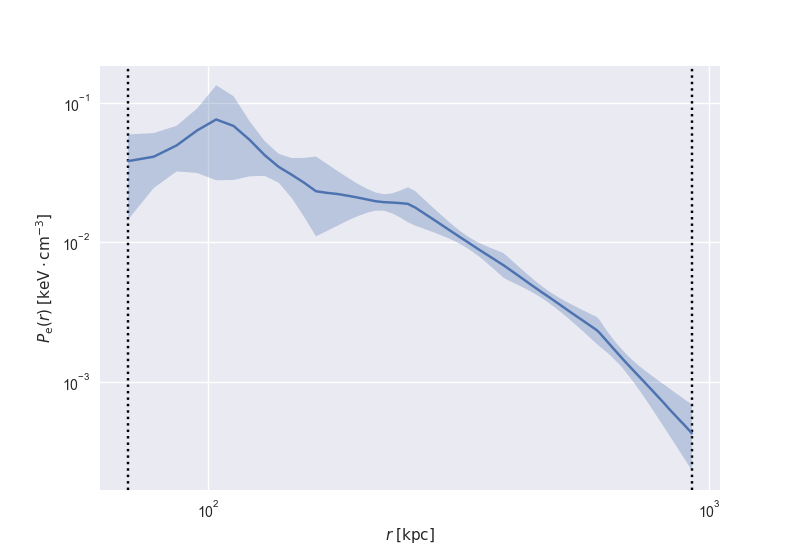

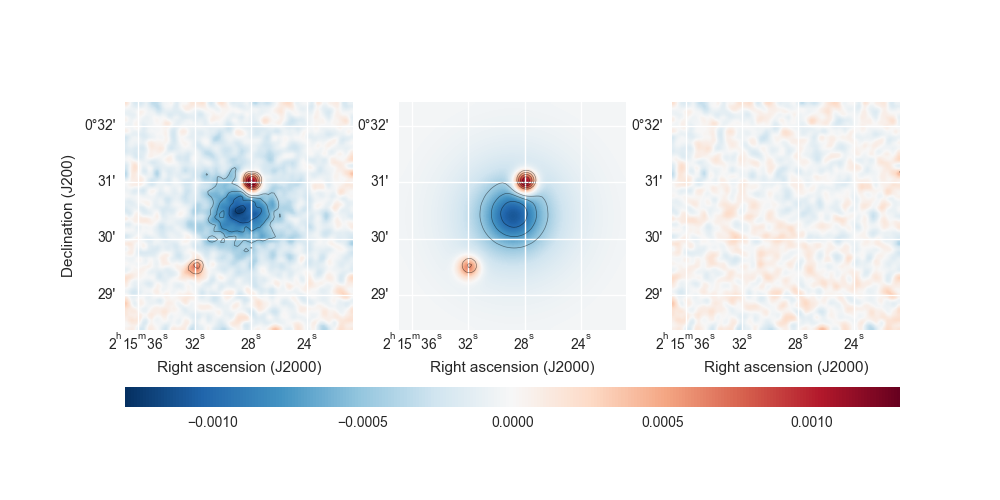

In [28]:
results.mcmc_trace_plot(chains_clean_noY, filename=f"{path}/trace.png")
results.mcmc_corner_plot(chains_clean_noY, filename=f"{path}/corner.png", model=ppf.model)
ax = results.plot_profile(chains_clean_noY, ppf, r_range=np.linspace(ppf.model.r_bins.min(), ppf.model.r_bins.max(), 100))
_ = results.plot_data_model_residuals(ppf, par_vec=ppf.model.par_dic2vec(chains_clean_noY.median()), lims="sym", smooth=1.0)